In [6]:
import pandas as pd
import numpy as np
from numpy import random
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model


In [7]:
# limiter=int(input('Enter a value for the maximum number of images in a class'))
data_path=r'/kaggle/input/plant-disease-classification-merged-dataset'
classes=os.listdir(data_path)
filepaths=[]
labels=[]
for klass in classes:
    classpath=os.path.join(data_path, klass)
    flist=os.listdir(classpath)
#     if len(flist) > limiter:
#         flist=np.random.choice(flist, limiter, replace=False)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)    
num_of_classes=len(classes)
print(df['labels'].value_counts())


labels
Grape__black_rot                  11390
Soybean__healthy                   5998
Soybean__caterpillar               3309
Tomato__yellow_leaf_curl_virus     3214
Peach__bacterial_spot              2297
                                  ...  
Soybean__bacterial_blight            56
Coffee__cercospora_leaf_spot         55
Sugarcane__red_stripe                53
Soybean__downy_mildew                51
Soybean__mosaic_virus                22
Name: count, Length: 88, dtype: int64


In [8]:
classes = {i:j for i,j in enumerate(df['labels'].unique())}
classes

{0: 'Tomato__septoria_leaf_spot',
 1: 'Tea__anthracnose',
 2: 'Rice__hispa',
 3: 'Soybean__diabrotica_speciosa',
 4: 'Tomato__healthy',
 5: 'Gauva__diseased',
 6: 'Wheat__yellow_rust',
 7: 'Soybean__downy_mildew',
 8: 'Pomegranate__diseased',
 9: 'Apple__rust',
 10: 'Tea__algal_leaf',
 11: 'Pomegranate__healthy',
 12: 'Tomato__early_blight',
 13: 'Peach__bacterial_spot',
 14: 'Soybean__healthy',
 15: 'Potato__healthy',
 16: 'Cherry__healthy',
 17: 'Apple__healthy',
 18: 'Rice__neck_blast',
 19: 'Wheat__septoria',
 20: 'Jamun__healthy',
 21: 'Strawberry___leaf_scorch',
 22: 'Coffee__rust',
 23: 'Mango__healthy',
 24: 'Mango__diseased',
 25: 'Apple__black_rot',
 26: 'Soybean__powdery_mildew',
 27: 'Lemon__healthy',
 28: 'Pepper_bell__healthy',
 29: 'Strawberry__healthy',
 30: 'Cassava__healthy',
 31: 'Corn__healthy',
 32: 'Jamun__diseased',
 33: 'Corn__common_rust',
 34: 'Tomato__yellow_leaf_curl_virus',
 35: 'Coffee__cercospora_leaf_spot',
 36: 'Grape__black_measles',
 37: 'Rice__health

Each image has shape: (256, 256, 3) ,dtype: float32, class of: Cherry__powdery_mildew


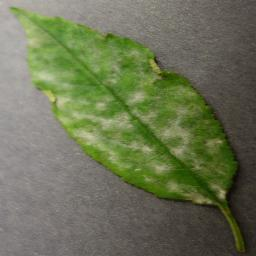

In [9]:
from tensorflow.keras.utils import img_to_array, load_img
# Load random smaple of plant disease 
random_sample = df.sample(n=1).iloc[0]
sample_image_path = random_sample['filepaths']
sample_image = load_img(sample_image_path)

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)
print(f"Each image has shape: {sample_array.shape} ,dtype: {sample_array.dtype}, class of: {random_sample['labels']}")
sample_image

In [10]:
train_df, test_df=train_test_split(df, train_size=.8, shuffle=True, stratify=df['labels'])
print(f'train_df lngth= {len(train_df)},  test_df length= {len(test_df)}')
total_train=train_df['labels'].value_counts()
print(f'the train_set contain {num_of_classes} class, total train each class is:\n {total_train}')

train_df lngth= 63269,  test_df length= 15818
the train_set contain 88 class, total train each class is:
 labels
Grape__black_rot                  9112
Soybean__healthy                  4798
Soybean__caterpillar              2647
Tomato__yellow_leaf_curl_virus    2571
Peach__bacterial_spot             1837
                                  ... 
Soybean__bacterial_blight           45
Coffee__cercospora_leaf_spot        44
Sugarcane__red_stripe               42
Soybean__downy_mildew               41
Soybean__mosaic_virus               18
Name: count, Length: 88, dtype: int64


In [13]:
total_test=test_df['labels'].value_counts()
print(f'the test_set contain {num_of_classes} class, total test each class is:\n {total_test}')

the test_set contain 88 class, total test each class is:
 labels
Grape__black_rot                  2278
Soybean__healthy                  1200
Soybean__caterpillar               662
Tomato__yellow_leaf_curl_virus     643
Peach__bacterial_spot              460
                                  ... 
Sugarcane__red_stripe               11
Coffee__cercospora_leaf_spot        11
Soybean__bacterial_blight           11
Soybean__downy_mildew               10
Soybean__mosaic_virus                4
Name: count, Length: 88, dtype: int64


In [14]:
img_size= (224,224)
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=img_size,
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    seed=42,
                                                    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=img_size,
                                                    batch_size=32,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    shuffle=False)


Found 63269 validated image filenames belonging to 88 classes.
Found 15817 validated image filenames belonging to 88 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [15]:
# image_batch, label_batch = next(val_images)
# image_batch.shape, label_batch.shape

In [16]:
def create_pre_trained_model():
  """
  Initializes an InceptionV3 model.
  
  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    
  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """

  pre_trained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
) 

  

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False



  return pre_trained_model

In [17]:
pre_trained_model = create_pre_trained_model()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [21]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [27]:
# Choose `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [34]:
x =tf.keras.layers.GlobalAveragePooling2D()(last_output)
x =tf.keras.layers.Dense(units=512, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=256, activation='relu')(x)
x =tf.keras.layers.Dropout(0.2)(x)
x =tf.keras.layers.Dense(units=128, activation='relu')(x)
x =tf.keras.layers.Dense(units=88, activation='softmax')(x)      

# Create the complete model by using the Model class
model = Model(inputs=pre_trained_model.input, outputs=x)

# Compile the model
model.compile(optimizer = 'adam', 
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 9,544,568 (36.41 MB)

 Trainable params: 569,304 (2.17 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    validation_data=test_generator,
    validation_steps=20,
    epochs=30,
    verbose=1
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/100 ━━━━━━━━━━━━━━━━━━━━ 41:15 25s/step - accuracy: 0.0000e+00 - loss: 4.5155

I0000 00:00:1717392810.553210     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 124s 996ms/step - accuracy: 0.1656 - loss: 3.8873 - val_accuracy: 0.3375 - val_loss: 2.7147
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 887ms/step - accuracy: 0.3570 - loss: 2.5502 - val_accuracy: 0.4234 - val_loss: 2.1339
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 883ms/step - accuracy: 0.4521 - loss: 1.9318 - val_accuracy: 0.5375 - val_loss: 1.5855
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 886ms/step - accuracy: 0.5275 - loss: 1.5341 - val_accuracy: 0.5828 - val_loss: 1.3779
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 898ms/step - accuracy: 0.5813 - loss: 1.3426 - val_accuracy: 0.6469 - val_loss: 1.1810
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 823ms/step - accuracy: 0.6251 - loss: 1.1720 - val_accuracy: 0.6719 - val_loss: 1.1149
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 796ms/step - accuracy: 0.6596 - loss: 1.0735 - val_accuracy: 0.6906 - val_loss: 1.0138
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 784ms/step - accuracy: 0.6707 - loss: 1.0262 - va

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 542ms/step - accuracy: 0.7723 - loss: 0.6856 - val_accuracy: 0.8078 - val_loss: 0.5826
Epoch 21/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 734ms/step - accuracy: 0.7803 - loss: 0.6535 - val_accuracy: 0.8125 - val_loss: 0.5779
Epoch 22/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 725ms/step - accuracy: 0.7865 - loss: 0.6113 - val_accuracy: 0.8188 - val_loss: 0.5052
Epoch 23/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 716ms/step - accuracy: 0.7696 - loss: 0.6806 - val_accuracy: 0.8047 - val_loss: 0.5416
Epoch 24/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 722ms/step - accuracy: 0.7877 - loss: 0.6654 - val_accuracy: 0.7812 - val_loss: 0.6217
Epoch 25/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 739ms/step - accuracy: 0.7964 - loss: 0.6081 - val_accuracy: 0.7812 - val_loss: 0.5983
Epoch 26/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 759ms/step - accuracy: 0.7969 - loss: 0.5609 - val_accuracy: 0.8422 - val_loss: 0.4560
Epoch 27/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 758ms/step - accuracy: 0.7751 - loss: 0.616

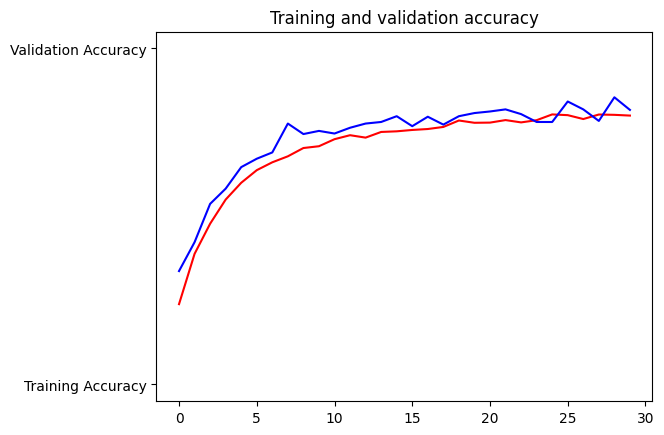

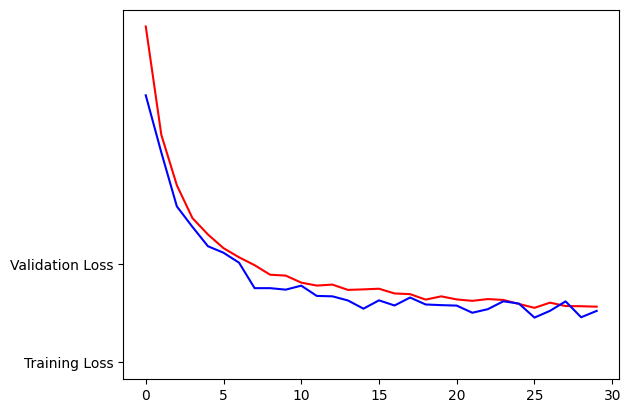

In [37]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()